In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class EWCOptimizer(optim.Adam):
    def __init__(self, params, fisher_info, orig_params, ewc_lambda=0.1, **kwargs):
        super().__init__(params, **kwargs)
        self.fisher_info = fisher_info
        self.orig_params = orig_params
        self.ewc_lambda = ewc_lambda

    def step(self, closure=None):
        loss = super().step(closure)
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        param_name = {v: k for k, v in model.named_parameters()}[p]
                        fisher = self.fisher_info[param_name]
                        orig_param = self.orig_params[param_name]
                        p.add_(self.ewc_lambda * fisher * (p - orig_param), alpha=-group['lr'])
        return loss



class AdaptiveEWCOptimizer(EWCOptimizer):
    def __init__(self, params, fisher_info, orig_params, ewc_lambda=0.1, lambda_min=0.01, lambda_max=10, **kwargs):
        super(AdaptiveEWCOptimizer, self).__init__(params, fisher_info, orig_params, ewc_lambda, **kwargs)
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max

    def step(self, closure=None):
        # Perform the original EWC optimizer step
        loss = super().step(closure)

        # Adjust ewc_lambda based on the magnitude of the gradients
        grad_magnitudes = [torch.norm(p.grad).item() if p.grad is not None else 0 for p in self.param_groups[0]['params']]
        mean_grad_magnitude = np.mean(grad_magnitudes)

        if mean_grad_magnitude > 1:  # Arbitrary threshold for 'steep' curvature
            self.ewc_lambda = min(self.ewc_lambda * 1.1, self.lambda_max)  # Increase penalty
        else:
            self.ewc_lambda = max(self.ewc_lambda * 0.9, self.lambda_min)  # Decrease penalty

        return loss


In [ ]:
def train_model(model, loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Step {i+1}/{len(loader)}, Loss: {loss.item()}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_loss_landscape_3d(model, test_loader, criterion, direction1, direction2, steps=20, scale=0.1):
    model.eval()
    param = next(model.parameters())
    original_weights = param.data.clone()
    perturbations1 = np.linspace(-scale, scale, steps)
    perturbations2 = np.linspace(-scale, scale, steps)

    X, Y = np.meshgrid(perturbations1, perturbations2)
    Z = np.zeros_like(X)

    with torch.no_grad():
        for i, perturb1 in enumerate(perturbations1):
            for j, perturb2 in enumerate(perturbations2):
                modified_weights = original_weights + direction1 * perturb1 + direction2 * perturb2
                param.data = modified_weights
                loss_accumulated = 0
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_accumulated += loss.item()
                Z[j, i] = loss_accumulated / len(test_loader)
        param.data = original_weights

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Perturbation in Direction 1')
    ax.set_ylabel('Perturbation in Direction 2')
    ax.set_zlabel('Loss')
    ax.set_title('3D Loss Landscape of Model')
    plt.show()


In [ ]:
def generate_random_directions(param):
    shape = param.shape
    direction1 = torch.randn(shape, device=param.device)
    direction2 = torch.randn(shape, device=param.device)

    # Flatten directions to compute orthogonalization and normalization
    dir1_flat = direction1.flatten()
    dir2_flat = direction2.flatten()

    # Orthogonalize direction2 relative to direction1
    proj = torch.dot(dir2_flat, dir1_flat) / torch.dot(dir1_flat, dir1_flat)
    dir2_flat -= proj * dir1_flat

    # Normalize both directions
    direction1 = direction1 / torch.norm(dir1_flat)
    direction2 = direction2 / torch.norm(dir2_flat)

    return direction1, direction2


In [ ]:
# Instantiate the model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()

# Train the baseline model
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, 10, optimizer, criterion)

Epoch 1/10, Step 1/782, Loss: 2.299947500228882
Epoch 1/10, Step 101/782, Loss: 1.749854564666748
Epoch 1/10, Step 201/782, Loss: 1.6955909729003906
Epoch 1/10, Step 301/782, Loss: 1.2993308305740356
Epoch 1/10, Step 401/782, Loss: 1.406023383140564
Epoch 1/10, Step 501/782, Loss: 1.1098499298095703
Epoch 1/10, Step 601/782, Loss: 1.1877213716506958
Epoch 1/10, Step 701/782, Loss: 1.1862642765045166
Epoch 2/10, Step 1/782, Loss: 1.001047968864441
Epoch 2/10, Step 101/782, Loss: 1.058518409729004
Epoch 2/10, Step 201/782, Loss: 0.9308940768241882
Epoch 2/10, Step 301/782, Loss: 1.037346363067627
Epoch 2/10, Step 401/782, Loss: 1.0201448202133179
Epoch 2/10, Step 501/782, Loss: 1.1267075538635254
Epoch 2/10, Step 601/782, Loss: 0.9234457612037659
Epoch 2/10, Step 701/782, Loss: 0.6494093537330627
Epoch 3/10, Step 1/782, Loss: 1.0363129377365112
Epoch 3/10, Step 101/782, Loss: 0.8078393340110779
Epoch 3/10, Step 201/782, Loss: 0.815529465675354
Epoch 3/10, Step 301/782, Loss: 0.9676460623

In [ ]:
# Compute Fisher information and original parameters
def compute_fisher_information(model, dataloader, criterion):
    fisher_information = {}
    for name, param in model.named_parameters():
        fisher_information[name] = torch.zeros_like(param.data)

    model.eval()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad.data ** 2

    for name in fisher_information:
        fisher_information[name] /= len(dataloader.dataset)

    return fisher_information

In [ ]:
fisher_info = compute_fisher_information(model, train_loader, criterion)
orig_params = {name: param.data.clone() for name, param in model.named_parameters()}

In [ ]:
ewc_optimizer = EWCOptimizer(model.parameters(), fisher_info, orig_params, ewc_lambda=0.1, lr=0.001)
train_model(model, train_loader, 10, ewc_optimizer, criterion)

Epoch 1/10, Step 1/782, Loss: 0.30807244777679443
Epoch 1/10, Step 101/782, Loss: 0.24334900081157684
Epoch 1/10, Step 201/782, Loss: 0.22792407870292664
Epoch 1/10, Step 301/782, Loss: 0.3599461615085602
Epoch 1/10, Step 401/782, Loss: 0.18580198287963867
Epoch 1/10, Step 501/782, Loss: 0.1906295120716095
Epoch 1/10, Step 601/782, Loss: 0.2875281274318695
Epoch 1/10, Step 701/782, Loss: 0.32399970293045044
Epoch 2/10, Step 1/782, Loss: 0.2268945872783661
Epoch 2/10, Step 101/782, Loss: 0.16116130352020264
Epoch 2/10, Step 201/782, Loss: 0.15170146524906158
Epoch 2/10, Step 301/782, Loss: 0.2337065488100052
Epoch 2/10, Step 401/782, Loss: 0.10578040778636932
Epoch 2/10, Step 501/782, Loss: 0.19840334355831146
Epoch 2/10, Step 601/782, Loss: 0.12469830363988876
Epoch 2/10, Step 701/782, Loss: 0.27870431542396545
Epoch 3/10, Step 1/782, Loss: 0.19553425908088684
Epoch 3/10, Step 101/782, Loss: 0.12916025519371033
Epoch 3/10, Step 201/782, Loss: 0.10102976113557816
Epoch 3/10, Step 301/78

In [ ]:
adaptive_ewc_optimizer = EWCOptimizer(model.parameters(), fisher_info, orig_params, ewc_lambda=0.1, lr=0.001)  # Replace with AdaptiveEWCOptimizer when defined
train_model(model, train_loader, 10, adaptive_ewc_optimizer, criterion)

Epoch 1/10, Step 1/782, Loss: 0.03709467500448227
Epoch 1/10, Step 101/782, Loss: 0.026302050799131393
Epoch 1/10, Step 201/782, Loss: 0.08305810391902924
Epoch 1/10, Step 301/782, Loss: 0.09761863201856613
Epoch 1/10, Step 401/782, Loss: 0.05203010514378548
Epoch 1/10, Step 501/782, Loss: 0.09294416010379791
Epoch 1/10, Step 601/782, Loss: 0.055429767817258835
Epoch 1/10, Step 701/782, Loss: 0.035215895622968674
Epoch 2/10, Step 1/782, Loss: 0.05889059975743294
Epoch 2/10, Step 101/782, Loss: 0.023015635088086128
Epoch 2/10, Step 201/782, Loss: 0.033421363681554794
Epoch 2/10, Step 301/782, Loss: 0.028582172468304634
Epoch 2/10, Step 401/782, Loss: 0.03682709112763405
Epoch 2/10, Step 501/782, Loss: 0.035056814551353455
Epoch 2/10, Step 601/782, Loss: 0.052012622356414795
Epoch 2/10, Step 701/782, Loss: 0.09313453733921051
Epoch 3/10, Step 1/782, Loss: 0.002910205628722906
Epoch 3/10, Step 101/782, Loss: 0.01229804940521717
Epoch 3/10, Step 201/782, Loss: 0.012318834662437439
Epoch 3/

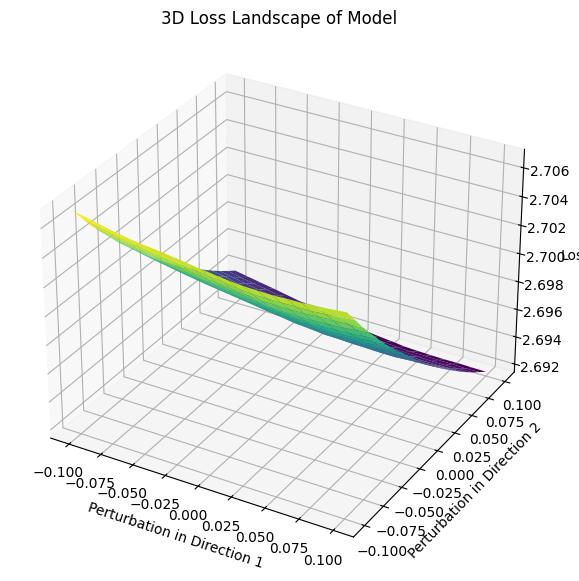

In [ ]:
# Get random directions based on the first parameter of the baseline model
direction1, direction2 = generate_random_directions(next(model.parameters()))

# Visualize the loss landscape for the baseline model
plot_loss_landscape_3d(model, test_loader, criterion, direction1, direction2)


